In [10]:
# Tutorial: https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python
from sklearn.utils import Bunch
import numpy as np
import pandas as pd

In [11]:
# Configuration

discovery_data_file = '../../data/Supp_Table_6_filtered_lfq_discovery.csv'

validation_data_file = '../../data/Supp_Table_3_lfq_intensities_validation.csv'
clinical_data_file = '../../data/Supp_Table_1_clinical_data.csv'


nine_prot_classifier = ['ENPP3', 'IVL', 'S100A2', 'MYH11', 'SERPINB5', 'NNMT', 'CLCA4', 'CD109', 'S100A14']
my_classifier = ['S100A2', 'S100A14', 'SERPINB5', 'S100P', 'NNMT', 'MIF', 'HSPA2', 'TPPP3', 'SYNGR2']
classifier = nine_prot_classifier

test_size = 0.15
random_state = 109

In [12]:
# Read discovery data
gene_df = pd.read_csv(discovery_data_file, sep=';', header=0)
gene_df = gene_df.drop(columns=['Razor + unique peptides', 'Unique peptides','Q-value', 
                      'Score', 'Intensity', 'MS/MS count', 'Protein IDs',
       'Majority protein IDs', 'Protein names', 'Column1', 'Column2',
       'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8',
       'Column9', 'Column10', 'Column11', 'Column12'])
gene_df = gene_df.fillna(value="labels", limit=1)
gene_df = gene_df.set_index('Gene names')
gene_df = gene_df.transpose()
mapping = {'Healthy': 0, 'Patient': 1}
gene_df = gene_df.replace({'labels': mapping})

display(gene_df.head(5))

Gene names,A1BG,A2M,AARS,ABCE1,ABCF1,ABHD14B,ABI1,ABR,ACADVL,ACAP2,...,YWHAE,YWHAG,YWHAH,YWHAQ,YWHAZ,ZAK;pk,ZC3HAV1,ZNF185,ZYX,labels
LFQ intensity BUL_103,25.39842,26.66044,23.51749,22.38195,20.65106,23.94708,22.80967,19.92877,23.40912,20.6044,...,27.00389,24.42918,23.72848,25.59167,27.46972,21.48316,21.66006,21.59405,23.42522,0
LFQ intensity BUL_30,28.04843,29.83939,24.725,21.4001,18.52887,25.35803,19.56752,18.04529,20.12199,19.46165,...,28.6475,25.80799,24.62271,27.62819,29.19315,21.95957,19.84275,20.02877,20.17072,0
LFQ intensity BUL_40,24.33402,25.49622,23.27213,22.20973,19.87752,23.89171,22.45669,21.20985,22.55173,20.05775,...,28.13482,25.42211,25.38281,26.26785,28.2209,19.78749,22.28619,22.10188,21.40671,0
LFQ intensity BUL_47,26.15509,29.6653,18.98055,19.4373,20.06988,23.32896,21.12136,17.5265,21.38506,20.32839,...,26.75646,23.68603,24.00967,24.367,28.00657,19.62387,18.94378,21.4315,22.04613,1
LFQ intensity BUL_48,25.64636,26.88064,22.68656,21.88852,20.69693,24.13485,22.49685,20.13295,22.7297,20.86507,...,27.03444,24.14499,24.0748,25.49063,27.62415,22.0415,20.7982,22.42206,22.2678,1


In [13]:
# Read Validation Data

gene_df = pd.read_csv(validation_data_file, sep=';', header=0)
gene_df = gene_df.drop(columns=['Razor + unique peptides', 'Unique peptides','Q-value', 
                      'Score', 'Intensity', 'MS/MS count', 'Protein IDs',
       'Majority protein IDs', 'Protein names', 'Column1', 'Column2',
       'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8',
       'Column9', 'Column10', 'Column11', 'Column12', 'Column13', 'Sequence coverage [%]', 'Mol. weight [kDa]' ])
gene_df = gene_df.drop(columns=['LFQ intensity MUL_38','LFQ intensity BUL_109','LFQ intensity UL_19',
    'LFQ intensity UL_22','LFQ intensity UL_3','LFQ intensity UL_23','LFQ intensity BUL_101','LFQ intensity UL_37',
    'LFQ intensity UL_35','LFQ intensity MUL_38','LFQ intensity MUL_69'])

gene_names = list(gene_df.columns)

gene_df = gene_df.fillna(value=0)
gene_df = gene_df.set_index('Gene names')
gene_df = gene_df.transpose()


clinical_data_df = pd.read_csv(clinical_data_file, sep=';', header=1)
clinical_data_df = clinical_data_df[clinical_data_df["Set"] == 'Validation']
clinical_data_df['Sample ID'] = clinical_data_df['Sample ID'].str.replace('-','_')
sample_col_list = clinical_data_df['Sample ID'].tolist()
sample_col_list = [('LFQ intensity '+ sample) for sample in sample_col_list]
clinical_data_df['samples'] = sample_col_list
clinical_data_df = clinical_data_df[['samples', 'Signature prediction2']]
### 'LFQ intensity UL_37' kommt in der Tabelle 3 nicht vor -> Warum auch immer?
clinical_data_df = clinical_data_df[clinical_data_df["samples"] != 'LFQ intensity UL_37']
clinical_data_df = clinical_data_df.set_index('samples')
clinical_data_df = clinical_data_df.rename(columns={'Signature prediction2': 'labels'})

gene_df = gene_df.join(clinical_data_df)
mapping = {'Healthy': 0, 'Patient': 1}
gene_df = gene_df.replace({'labels': mapping})

display(gene_df.head(5))

,A1BG,A2M,A2ML1,A4GALT,AAAS,AACS,AAGAB,AAK1,AAK1,AAMDC,...,0,0,0,0,0,0,0,0,0,labels
LFQ intensity BUL_1,31.395758,36.772396,27.792532,0.000000,0.000000,22.145134,0.0,0.0,0.0,23.470604,...,0.0,27.319414,29.749304,22.809332,0.0,31.016443,24.910404,28.295309,24.061346,1
LFQ intensity BUL_10,32.131454,35.449760,31.344879,25.675083,0.000000,0.000000,0.0,0.0,0.0,24.782917,...,0.0,29.630342,25.440632,0.000000,0.0,0.000000,0.000000,25.624609,24.216824,1
LFQ intensity BUL_102,32.093391,34.859440,29.944473,0.000000,23.829971,0.000000,0.0,0.0,0.0,24.514847,...,0.0,29.479427,27.577660,0.000000,0.0,31.627102,0.000000,28.808054,26.070568,1
LFQ intensity BUL_11,33.692703,33.655441,26.212952,0.000000,0.000000,0.000000,0.0,0.0,0.0,24.164536,...,0.0,25.615097,28.372355,0.000000,0.0,31.508053,0.000000,24.047102,24.458326,1
LFQ intensity BUL_111,30.580734,33.720184,31.121702,24.418991,0.000000,22.818605,0.0,0.0,0.0,0.000000,...,0.0,29.538399,25.757990,0.000000,0.0,29.498859,0.000000,0.000000,0.000000,1


In [14]:
label_col = gene_df['labels']
data_cols = gene_df[classifier]

In [15]:
# generate numpy bunch
gene_data = pd.DataFrame(data_cols).to_numpy()
feature_names = np.asarray(classifier)
target_names = np.asarray(['Healthy','Patient'])
gene_target = np.asarray(label_col.values.tolist())

genes = Bunch(data=gene_data, feature_names=feature_names, target_names=target_names, target=gene_target)


In [16]:
# print the names of the 13 features
print("Features: ", genes.feature_names)

# print the label type of cancer('malignant' 'benign')
print("Labels: ", genes.target_names)

# print data(feature)shape
#print(f"Shape: {cancer.data.shape}")
print(f"Shape: {genes.data.shape}")

# print the cancer data features (top 5 records)
#print(cancer.data[0:5])
#print(f"top 5 records: {cancer.data[0:5]}")
print(f"top 5 records: {genes.data[0:5]}")

# print the cancer labels (0:malignant, 1:benign)
#print(cancer.target)
#print(f"Target: {cancer.target}")
print(f"Target: {genes.target}")

# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(genes.data, genes.target, test_size=0.15,random_state=109) # 70% training and 30% test

#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))


from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Model Sensitivity
print(f"Sensitivity im Paper 70% (== recall): {tp/ (tp+fn)}")

# Model Specifity
print(f"Specifity im Paper 76.2%: {tn / (tn+fp)}")

Features:  ['ENPP3' 'IVL' 'S100A2' 'MYH11' 'SERPINB5' 'NNMT' 'CLCA4' 'CD109'
 'S100A14']
Labels:  ['Healthy' 'Patient']
Shape: (151, 12)
top 5 records: [[33.28153992 27.79600143 28.78022194 27.95121574 29.61368561 35.25078201
   0.         26.93438339 26.23430824 29.09086037 26.78730965 31.11947823]
 [27.6853199  30.50549889 29.82668877 32.44255447  0.         25.85295677
   0.         31.15768051 27.5042305  32.28887177 25.00161362 30.8419857 ]
 [19.78241539 29.4571476  30.36264801 26.16449738  0.         23.53171921
   0.         30.2375164  25.26631546 32.68170929 21.80384636 31.45135307]
 [25.35685921 26.18940926 28.24789619  0.          0.         25.86990166
   0.         28.49716568 25.2577095  27.10169411 21.09821892 29.3266964 ]
 [24.10749245 30.76453781 27.41377068  0.          0.         23.51989365
   0.         31.81676865 27.34595871 33.0910759  20.94785118 32.39404678]]
Target: [1 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0
 0 0 1 0 1 0 0 1 1 

In [17]:
# k-fold cross validation

X = genes.data
y = genes.target

from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear')
scores = cross_val_score(clf, X, y, cv=5)

print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

[0.74193548 0.83333333 0.76666667 0.7        0.9       ]
0.79 accuracy with a standard deviation of 0.07


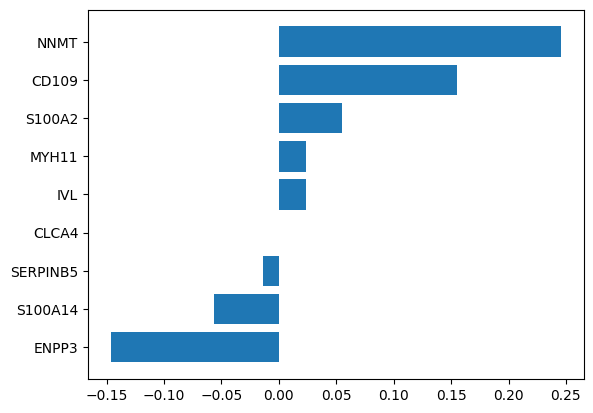

In [18]:
# importances

from matplotlib import pyplot as plt
from sklearn import svm

def f_importances(coef, names):
    imp = coef    
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = classifier
clf = svm.SVC(kernel='linear')
clf.fit(X, y)
f_importances(clf.coef_[0], features_names)